# Filtering out uptake and transfer from my doubling time analyses

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from macrohet import visualise
from tqdm.auto import tqdm
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import r2_score

# Conversion factor
meters_per_pixel = 1.4949402023919043E-07  # Micrometers per pixel
micrometers_per_pixel = meters_per_pixel*1E6 # Micrometers per pixel

# set display params
sns.set(style = 'white')
# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Nimbus Sans'
# import matplotlib as mpl
# mpl.rcdefaults()
# Get the color palette of the PiYG color map
colours = expanded_piyg = visualise.color_palette('expanded_piyg').colors
sns.set_palette(expanded_piyg)
import tempfile
import napari
import glob
import imageio
import skimage.transform
import shutil

#### Function

In [2]:
def plot(ID, df, save = False, napari = False):
    # Get single-cell trajectory in df format
    sc_df = df[df['ID'] == ID]
    # Drop NaN values specifically from the required columns
    sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
    # Ensure there is temporal order
    sc_df = sc_df.sort_values(by='Time Model (hours)')
    
    # Extract Strain, Compound, and Concentration for the title
    strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
    
    # Calculate the R2 value and skip plotting if R2 < 0.7
    r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
    df.loc[df['ID'] == ID, 'r2'] = r2
    if r2 < 0.7:
        # ill_fitting_curves[ID] = r2
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        print(f'Nee fitting ({r2})')
        # return
    
    # Find the temporal order of the minimum and maximum
    min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
    max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
    
    # perform a check on the data
    if max_value <= min_value:
        #non_doubling_curves.append(ID)
        print(f'No population doubling for ID {ID}')
    
    # Find the time indices of the minimum and maximum
    min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
    max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
    
    # Check if maximum occurs before minimum
    if max_index > min_index:
        growth = True
        # Minimum occurs before the maximum (indicating growth)
        # Start from the minimum and double
        N_i = min_value
        N_series = []
        
        # Generate the doubling series
        while N_i <= max_value:
            N_series.append(N_i)
            N_i *= 2
        
    else:
        growth = False
        # non_doubling_curves.append(ID)
        print(f'No obvious growth for ID {ID}')
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        # return
        # Maximum occurs before the minimum (indicating a reduction)
        # Start from the maximum and halve
        N_i = max_value
        N_series = []
        
        # Generate the halving series
        while N_i >= min_value:
            N_series.append(N_i)
            N_i /= 2
    
    # Check if there are no valid doubling points
    if len(N_series) < 2:
        #non_doubling_curves.append(ID)
        print(f'No population doubling for ID {ID}')
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        # return
        
    # Find the indices and corresponding times for each doubling point
    doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
    doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
    doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
    # if not growth:
    #     doubling_times = [-t for t in doubling_times]
    #     N_series = [-n for n in N_series]  
    
    # Incorporate N_series and doubling_times into the main DataFrame
    # Assign lists to all entries in df with the same ID
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
    # df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
    # # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
        
    # Plot the experimental data and the fitted model
    plt.figure(figsize=(8, 6))
    plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
    plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
    
    # Annotate doubling times and draw faint lines
    for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
        time = abs(time)
        population = abs(population)
        color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
        # Draw faint vertical lines at doubling time points
        plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        
        # Place a text label indicating the doubling time
        if i > 0:  # Start labeling from the second point
            previous_time = doubling_time_points.iloc[i-1]
            
            # Midpoint between the two lines
            label_x_pos = time  # Correct the label position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
    
            # Calculate the gap between the lines and scale the font size
            gap = time - previous_time
            scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
            
            # Draw the horizontal doubling time label
            plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                     ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
            
            # Draw vertical arrow showing the change in N_series (doubling amount)
            deltaMtb = population - N_series[i-1]
            
            # Midpoint for the vertical delta annotation
            text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
            text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
    
            # Midpoint between the two lines
            label_x_pos = time + 0.1  # Adjust x-position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population - (max_value * 0.01)
            
            # Place the vertical label using plt.text
            plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                     fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
    
    # Add labels, legend, and titles
    plt.xlabel('Time (Hours)')
    plt.ylabel('Mtb Area µm$^{2}$')
    plt.legend()
        # Main title
    plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                 weight='bold', fontsize=16)
    # Subtitle
    plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
    
    sns.despine(offset=10)
    plt.grid(False)
    
    if save:    
        plt.savefig(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf', bbox_inches = 'tight', dpi = 314)
        # plt.close()
    if napari:
        # Save the current plot to a temporary file
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp_plot:
            plt.savefig(tmp_plot.name, bbox_inches='tight', dpi=314)
            plot_image_path = tmp_plot.name
        plot_image = imageio.imread(plot_image_path)
        # Resize the plot image to have a width of 750 pixels, maintaining aspect ratio
        height, width = plot_image.shape[:2]
        new_width = 750
        scale_factor = new_width / width
        new_height = int(height * scale_factor)
        resized_plot_image = skimage.transform.resize(plot_image, (new_height, new_width), anti_aliasing=True)
        viewer.add_image(resized_plot_image, name=f'ID: {ID} Plot', )#colormap='gray')
        return doubling_times, N_series
    else:    
        plt.show()

def regen(ID, df):
    # Get single-cell trajectory in df format
    sc_df = df[df['ID'] == ID]
    # Drop NaN values specifically from the required columns
    sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
    # Ensure there is temporal order
    sc_df = sc_df.sort_values(by='Time Model (hours)')
    # Extract Strain, Compound, and Concentration for the title
    strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
    # Calculate the R2 value and skip plotting if R2 < 0.7
    r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
    df.loc[df['ID'] == ID, 'r2'] = r2
    if r2 < 0.7:
        # ill_fitting_curves[ID] = r2
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        print(f'Nee fitting ({r2})')
        return
    
    # Find the temporal order of the minimum and maximum
    min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
    max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
    
    # perform a check on the data
    if max_value <= min_value:
        print(f'No population doubling for ID {ID}')
    
    # Find the time indices of the minimum and maximum
    min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
    max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
    
    # Check if maximum occurs before minimum
    if max_index > min_index:
        growth = True
        # Minimum occurs before the maximum (indicating growth)
        N_i = min_value
        N_series = []
        
        # Generate the doubling series
        while N_i <= max_value:
            N_series.append(N_i)
            N_i *= 2
        
    else:
        growth = False
        print(f'No obvious growth for ID {ID}')
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        return
    
    # Check if there are no valid doubling points
    if len(N_series) < 2:
        print(f'No population doubling for ID {ID}')
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        return
        
    # Find the indices and corresponding times for each doubling point
    doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
    doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
    doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
    # Incorporate N_series and doubling_times into the main DataFrame
    df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
    df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
        
    # Plot the experimental data and the fitted model
    plt.figure(figsize=(8, 6))
    plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
    plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
    
    # Annotate doubling times and draw faint lines
    for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
        time = abs(time)
        population = abs(population)
        color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
        # Draw faint vertical lines at doubling time points
        plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        
        # Place a text label indicating the doubling time
        if i > 0:  # Start labeling from the second point
            previous_time = doubling_time_points.iloc[i-1]
            
            # Midpoint between the two lines
            label_x_pos = time  # Correct the label position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
    
            # Calculate the gap between the lines and scale the font size
            gap = time - previous_time
            scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
            
            # Draw the horizontal doubling time label
            plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                     ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
            
            # Draw vertical arrow showing the change in N_series (doubling amount)
            deltaMtb = population - N_series[i-1]
            
            # Midpoint for the vertical delta annotation
            text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
            text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
    
            # Midpoint between the two lines
            label_x_pos = time + 0.1  # Adjust x-position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population - (max_value * 0.01)
            
            # Place the vertical label using plt.text
            plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                     fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
    
    # Add labels, legend, and titles
    plt.xlabel('Time (Hours)')
    plt.ylabel('Mtb Area µm$^{2}$')
    plt.legend()
    # Main title
    plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                 weight='bold', fontsize=16)
    # Subtitle
    plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
    
    sns.despine(offset=10)
    plt.grid(False)

    previous_fn = glob.glob(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/{ID}_dtmin*.pdf')[0]
    archive_dir = f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx'
    if previous_fn:
        # Move the file to the archive directory
        shutil.move(previous_fn, os.path.join(archive_dir, os.path.basename(previous_fn)))
        print(f"Moved {previous_fn} to {archive_dir}")
    
    plt.savefig(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf', bbox_inches = 'tight', dpi = 314)
    plt.close()

## Load params and data

In [3]:
output_dir = '/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4'#/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480/'#'/Users/dayn/data/macrohet_mac/temp_results/'#
os.makedirs(output_dir, exist_ok = True)

In [4]:
# dt_df= pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/arx/dt_df.pkl')
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/ND4_sc_df.pkl') #sc_df.pkl
df

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Unique ID,ID,Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),Frame,Edge Status,r2,Doubling Amounts,Doubling Times
0,0.0,0.000000,0.000000,1430.122786,-684.600439,0.0,0.0,0.0,535.972046,36.392685,...,282.3.1,282.3.1.ND0004,NaN,NaN,NaN,0.0,True,NaN,NaN,NaN
1,0.5,0.000000,0.000000,1553.352206,-684.600439,0.0,0.0,0.0,517.281433,31.998940,...,282.3.1,282.3.1.ND0004,NaN,NaN,NaN,1.0,True,NaN,NaN,NaN
2,1.0,0.000000,0.000000,2206.284874,-684.600439,0.0,0.0,0.0,503.972534,27.664877,...,282.3.1,282.3.1.ND0004,NaN,NaN,NaN,2.0,True,NaN,NaN,NaN
3,1.5,NaN,0.000000,NaN,-684.600439,NaN,0.0,0.0,493.696564,22.767044,...,282.3.1,282.3.1.ND0004,NaN,NaN,NaN,3.0,True,NaN,NaN,NaN
4,2.0,0.000000,0.000000,806.824178,-684.600439,0.0,0.0,0.0,477.338898,15.456922,...,282.3.1,282.3.1.ND0004,NaN,0.0,0.0,4.0,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802672,74.5,95.562024,-38.908672,945.518734,-1344.930448,1.0,1.0,1.0,432.996796,159.980438,...,5015.6.12,5015.6.12.ND0004,85.88514,NaN,NaN,149.0,False,0.63,None,None
802673,75.0,94.623388,-38.908672,1361.825886,-1344.930448,1.0,1.0,1.0,433.311157,166.972198,...,5015.6.12,5015.6.12.ND0004,85.88514,NaN,NaN,150.0,False,0.63,None,None
802674,75.5,83.091582,-38.908672,1152.510190,-1344.930448,1.0,1.0,1.0,435.046844,160.506119,...,5015.6.12,5015.6.12.ND0004,85.661655,NaN,NaN,151.0,False,0.63,None,None
802675,76.0,77.750300,-38.908672,1126.139005,-1344.930448,1.0,1.0,1.0,433.829651,157.600281,...,5015.6.12,5015.6.12.ND0004,84.331922,NaN,NaN,152.0,False,0.63,None,None


In [44]:
for ID in tqdm(IDs):
    try:
        # Get single-cell trajectory in df format
        sc_df = df[df['ID'] == ID]
        # Drop NaN values specifically from the required columns
        sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
        # Ensure there is temporal order
        sc_df = sc_df.sort_values(by='Time Model (hours)')
        
        # Extract Strain, Compound, and Concentration for the title
        strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
        
        # Calculate the R2 value and skip plotting if R2 < 0.7
        r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
        df.loc[df['ID'] == ID, 'r2'] = r2
        if r2 < 0.7:
            ill_fitting_curves[ID] = r2
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            print(f'Nee fitting ({r2})')
            continue
        
        # Find the temporal order of the minimum and maximum
        min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
        max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
        
        # perform a check on the data
        if max_value <= min_value:
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
        
        # Find the time indices of the minimum and maximum
        min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
        max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
        
        # Check if maximum occurs before minimum
        if max_index > min_index:
            growth = True
            # Minimum occurs before the maximum (indicating growth)
            # Start from the minimum and double
            N_i = min_value
            N_series = []
            
            # Generate the doubling series
            while N_i <= max_value:
                N_series.append(N_i)
                N_i *= 2
            
        else:
            growth = False
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            continue
            # Maximum occurs before the minimum (indicating a reduction)
            # Start from the maximum and halve
            # N_i = max_value
            # N_series = []
            
            # # Generate the halving series
            # while N_i >= min_value:
            #     N_series.append(N_i)
            #     N_i /= 2
        
        
        # Check if there are no valid doubling points
        if len(N_series) < 2:
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            continue
            
        # Find the indices and corresponding times for each doubling point
        doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
        doubling_time_indices = [np.abs(sc_df['Mtb Area Model (µm)'] - value).idxmin() for value in N_series]
        doubling_time_points = sc_df['Time Model (hours)'].loc[doubling_time_indices]
        doubling_times = doubling_time_points.diff().dropna().values.tolist()
        
        if not growth:
            doubling_times = [-t for t in doubling_times]
            N_series = [-n for n in N_series]  
        
        # Incorporate N_series and doubling_times into the main DataFrame
        # Assign lists to all entries in df with the same ID
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
        df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
        # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
            
        # Plot the experimental data and the fitted model
        plt.figure(figsize=(8, 6))
        plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
        plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
        
        # Annotate doubling times and draw faint lines
        for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
            time = abs(time)
            population = abs(population)
            color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
            # Draw faint vertical lines at doubling time points
            plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
            plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
            
            # Place a text label indicating the doubling time
            if i > 0:  # Start labeling from the second point
                previous_time = doubling_time_points.iloc[i-1]
                
                # Midpoint between the two lines
                label_x_pos = time  # Correct the label position
                # Adjust y-position to place the label just above the horizontal line
                label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
        
                # Calculate the gap between the lines and scale the font size
                gap = time - previous_time
                scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
                
                # Draw the horizontal doubling time label
                plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                         ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
                
                # Draw vertical arrow showing the change in N_series (doubling amount)
                deltaMtb = population - N_series[i-1]
                
                # Midpoint for the vertical delta annotation
                text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
                text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
        
                # Midpoint between the two lines
                label_x_pos = time + 0.1  # Adjust x-position
                # Adjust y-position to place the label just above the horizontal line
                label_y_pos = population - (max_value * 0.01)
                
                # Place the vertical label using plt.text
                plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                         fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
        
        # Add labels, legend, and titles
        plt.xlabel('Time (Hours)')
        plt.ylabel('Mtb Area µm$^{2}$')
        plt.legend()
        # Main title
        plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                     weight='bold', fontsize=16)
        # Subtitle
        plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
        
        sns.despine(offset=10)
        plt.grid(False)
        
        plt.savefig(os.path.join(output_dir, f'{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf'), bbox_inches = 'tight', dpi = 314)
        plt.close()
    
    except Exception as e:
        # Log the exception with traceback
        logging.error(f"Error while processing ID {ID}: {e}")
        logging.error(traceback.format_exc())
        print(f"An error occurred while processing ID {ID}. Check error_log.log for details.")

  0%|          | 0/3038 [00:00<?, ?it/s]

Nee fitting (0.45)
Nee fitting (0.37)
Nee fitting (0.54)
No population doubling for ID 10.3.10.ND0002
Nee fitting (0.51)
Nee fitting (0.59)
No population doubling for ID 1005.3.7.PS0000
Nee fitting (0.68)
Nee fitting (0.46)
No population doubling for ID 101.5.11.ND0003
Nee fitting (0.46)
Nee fitting (0.48)
Nee fitting (0.28)
No population doubling for ID 1019.3.10.ND0002
Nee fitting (0.51)
No population doubling for ID 102.6.8.ND0002
No population doubling for ID 102.6.8.PS0000
Nee fitting (0.62)
Nee fitting (0.6)
Nee fitting (0.66)
Nee fitting (0.42)
Nee fitting (0.29)
Nee fitting (0.43)
Nee fitting (0.57)
Nee fitting (0.44)
Nee fitting (0.63)
Nee fitting (0.63)
Nee fitting (0.53)
Nee fitting (-0.26)
Nee fitting (0.69)
Nee fitting (0.48)
Nee fitting (0.11)
Nee fitting (0.15)
Nee fitting (0.55)
Nee fitting (0.68)
Nee fitting (0.51)
No population doubling for ID 104.4.3.ND0002
Nee fitting (-0.44)
No population doubling for ID 104.6.8.PS0000
No population doubling for ID 104.6.9.PS0000
N

# strip plot

N=330


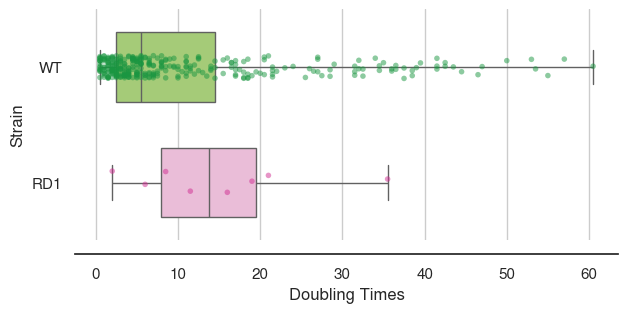

In [5]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] != 'UNI') 
             & (df['Compound'] == 'CTRL')
             # & (df['mtb_origin'] != 'Junk')
               ].drop_duplicates(subset=['ID'])
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')
# Initialize the figure (without logarithmic scale as doubling times are likely linear)
f, ax = plt.subplots(figsize=(7, 3))

# Create the boxplot for the doubling times by strain
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Strain", hue="Strain", 
    whis=[0, 100], width=.6, palette=[expanded_piyg[1], expanded_piyg[-2]]
)

# Add a stripplot to show each observation
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Strain", size=4, hue="Strain", palette=[expanded_piyg[0], expanded_piyg[-1]],
    alpha = 0.5
)

# Tweak the visual presentation
ax.xaxis.grid(True)
# ax.set(ylabel="")  # Remove y-axis label for a cleaner look
sns.despine(offset = 10, left=True)

# Save the figure
# plt.savefig(os.path.join(output_dir, 'boxplot_stripplot_doubling_times.pdf'), dpi=314)
plt.show()

In [13]:
# Prepare the subset DataFrame, filtering for WT strain or CTRL with RD1
subset_df = df[((df['Strain'] == 'WT') | ((df['Strain'] == 'RD1') & (df['Compound'] == 'CTRL'))) 
             & (df['r2'] >= 0.8) 
            & (df['Compound'] != 'BDQ')
             & (df['Edge Status'] == False) 
             # & ((df['mtb_origin'] == 'Growth') | (df['mtb_origin'].isna()))  # mtb_origin is either 'Growth' or NaN
              ].drop_duplicates(subset=['ID'])

# Continue with the usual process of exploding and filtering Doubling Times
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')



N=961


In [13]:
subset_df['Mtb Strain or Drug Compound'].unique()

array(['WT (CTRL)', 'PZA', 'RIF', 'INH', 'BDQ', 'RD1 (CTRL)'],
      dtype=object)

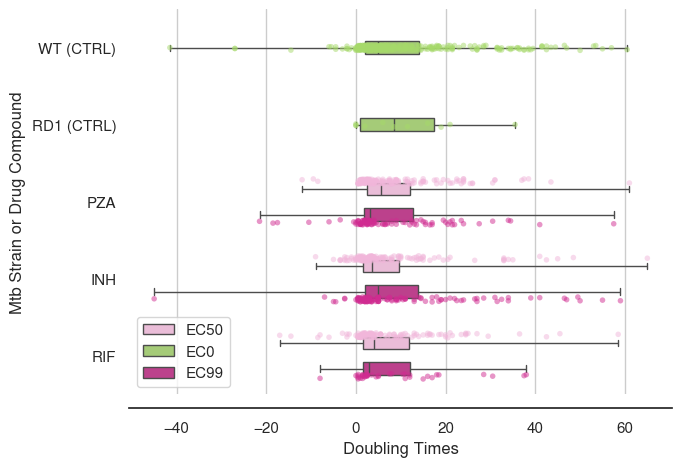

In [8]:
# Modify the DataFrame to place both WT and RD1 under the CTRL compound row
subset_df['Mtb Strain or Drug Compound'] = subset_df.apply(
    lambda row: f"{row['Strain']} (CTRL)" if row['Compound'] == 'CTRL' else row['Compound'], axis=1
)

# Define the desired order with WT and RD1 at the top
strain_order = ['WT (CTRL)', 'RD1 (CTRL)', 'PZA', 'INH', 'RIF']

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 5))

# Define hue_order for consistency
hue_order = ['EC50', 'EC0', 'EC99']

# Create the boxplot with specified y-axis order
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Mtb Strain or Drug Compound", hue="Concentration", 
    whis=[0, 100], width=.5, palette= [expanded_piyg[4],expanded_piyg[1], expanded_piyg[5]], 
    hue_order=hue_order, order=strain_order
)

# Add the stripplot with the same y-axis order
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Mtb Strain or Drug Compound", hue="Concentration", size=4, 
    palette=[expanded_piyg[4],expanded_piyg[1], expanded_piyg[5]], 
    hue_order=hue_order, dodge=True, alpha=0.5, order=strain_order
)

# Remove the double legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3])

# Tweak visual presentation
ax.xaxis.grid(True)
sns.despine(offset=10, left=True)

# Show the plot
plt.show()

# Adding more datapoints

### Adding between r2 0.7, 0.8

In [79]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.7) 
             & (df['r2'] < 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] == 'WT') 
             # & (df['Compound'] == 'CTRL')
             & (df['mtb_origin'].isna()) # are we really doing this right now? or after figure 3? 
               ].drop_duplicates(subset=['ID'])
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')
IDs = subset_df.drop_duplicates('ID').sort_values('Doubling Times').ID.values
print(f'Number of unique IDs={len(IDs)}')

N=157
Number of unique IDs=99


### Adding more EC99 RIF despite R2

In [122]:
test = df[(df['Strain'] == 'WT') 
& (df['Compound'] == 'RIF') 
& (df['Concentration'] == 'EC99') ].drop_duplicates('ID')
test = test[test['Doubling Times'].notna()]
test = test.explode('Doubling Times')
test = test[test['Doubling Times'] > 0 ]
test = test[test['mtb_origin'].isna()]
test = test[test['Edge Status'] == False]

In [123]:
test.ID.unique()

array(['238.4.7.ND0002'], dtype=object)

### Adding more RIF EC99 from ND4

In [24]:
# Prepare the subset DataFrame, filtering for WT strain or CTRL with RD1
subset_df = df[((df['Strain'] == 'WT') | ((df['Strain'] == 'RD1') & (df['Compound'] == 'CTRL'))) 
             & (df['r2'] < 0.8) 
            & (df['Compound'] != 'BDQ')
            # & (df['Compound'] == 'RIF')
            & (df['Concentration'] == 'EC99')
             & (df['Edge Status'] == False) 
             # & ((df['mtb_origin'] == 'Growth') | (df['mtb_origin'].isna()))
            & (df['mtb_origin'].isna())# mtb_origin is either 'Growth' or NaN
              ].drop_duplicates(subset=['ID'])

# Continue with the usual process of exploding and filtering Doubling Times
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')

N=130


In [25]:
subset_df

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,ID,Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),Frame,Edge Status,r2,Doubling Amounts,Doubling Times,mtb_origin
419080,0.0,98.601415,-53.323431,1212.761644,-978.281579,1.0,1.0,1.0,696.995483,281.722961,...,404.4.5.ND0004,NaN,NaN,NaN,0.0,False,0.78,"[104.4, 208.8]",53.0,NaN
421066,0.0,0.000000,21.074600,438.163948,50.619267,0.0,0.0,1.0,893.179016,422.259888,...,666.4.5.ND0004,NaN,NaN,NaN,0.0,False,0.73,"[1.92, 3.84, 7.68, 15.36]",10.5,NaN
421066,0.0,0.000000,21.074600,438.163948,50.619267,0.0,0.0,1.0,893.179016,422.259888,...,666.4.5.ND0004,NaN,NaN,NaN,0.0,False,0.73,"[1.92, 3.84, 7.68, 15.36]",7.0,NaN
421066,0.0,0.000000,21.074600,438.163948,50.619267,0.0,0.0,1.0,893.179016,422.259888,...,666.4.5.ND0004,NaN,NaN,NaN,0.0,False,0.73,"[1.92, 3.84, 7.68, 15.36]",12.0,NaN
422248,0.0,0.000000,1.564392,295.603108,78.644238,0.0,0.0,1.0,765.685303,538.046631,...,599.4.5.ND0004,NaN,NaN,NaN,0.0,False,0.72,"[1.92, 3.84, 7.68]",2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599850,25.0,6.414009,72.297275,1308.167228,-717.139800,1.0,1.0,1.0,239.285477,993.038269,...,3731.4.10.ND0004,NaN,NaN,NaN,50.0,False,0.79,"[3.3, 6.6, 13.2, 26.4, 52.8]",2.5,NaN
599850,25.0,6.414009,72.297275,1308.167228,-717.139800,1.0,1.0,1.0,239.285477,993.038269,...,3731.4.10.ND0004,NaN,NaN,NaN,50.0,False,0.79,"[3.3, 6.6, 13.2, 26.4, 52.8]",4.5,NaN
602261,30.0,51.423811,40.204883,527.691887,-147.768031,1.0,1.0,1.0,577.764465,505.685394,...,4403.4.10.ND0004,NaN,NaN,NaN,60.0,False,0.77,"[21.3, 42.6, 85.2, 170.4]",6.5,NaN
602261,30.0,51.423811,40.204883,527.691887,-147.768031,1.0,1.0,1.0,577.764465,505.685394,...,4403.4.10.ND0004,NaN,NaN,NaN,60.0,False,0.77,"[21.3, 42.6, 85.2, 170.4]",8.0,NaN


### Sort by lowest values of DT

In [26]:
IDs = subset_df.drop_duplicates('ID').sort_values('Doubling Times').ID.values

In [27]:
subset_df.drop_duplicates('ID').sort_values('Doubling Times')

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,ID,Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),Frame,Edge Status,r2,Doubling Amounts,Doubling Times,mtb_origin
441048,20.0,0.000000,28.538986,286.350845,759.758317,0.0,0.0,1.0,896.801758,978.750244,...,2751.4.5.ND0004,NaN,NaN,NaN,40.0,False,0.72,"[1.92, 3.84, 7.68, 15.36, 30.72]",0.5,NaN
442425,24.0,0.000000,30.527999,357.776530,-73.973410,0.0,0.0,1.0,171.038361,497.169952,...,3210.4.5.ND0004,NaN,NaN,NaN,48.0,False,0.74,"[1.92, 3.84, 7.68, 15.36, 30.72]",0.5,NaN
581382,0.0,0.000000,42.395033,354.513654,587.608114,0.0,0.0,1.0,794.263733,478.447968,...,508.4.10.ND0004,NaN,NaN,NaN,0.0,False,0.78,"[1.92, 3.84, 7.68, 15.36, 30.72]",0.5,NaN
463211,0.0,0.000000,18.325739,298.374317,227.686132,0.0,0.0,1.0,869.711853,991.938660,...,307.4.6.ND0004,NaN,NaN,NaN,0.0,False,0.70,"[1.92, 3.84, 7.68, 15.36]",0.5,NaN
473509,11.5,0.000000,71.403336,338.199277,637.311093,0.0,0.0,1.0,158.106827,468.673737,...,2036.4.6.ND0004,NaN,NaN,NaN,23.0,False,0.77,"[5.1, 10.2, 20.4, 40.8]",1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565013,9.0,2.726512,57.636684,358.134105,474.323759,1.0,1.0,1.0,1011.708923,238.815338,...,1512.4.9.ND0004,NaN,NaN,NaN,18.0,False,0.71,"[30.3, 60.6]",36.0,NaN
455460,0.0,15.934453,1.474998,1395.125094,246.525885,1.0,1.0,1.0,1080.946289,402.497559,...,686.4.6.ND0004,NaN,NaN,NaN,0.0,False,0.79,"[15.5, 31.0]",37.5,NaN
456783,0.0,4.469692,1.743180,1118.629921,516.093035,1.0,1.0,1.0,633.022461,555.314941,...,619.4.6.ND0004,NaN,NaN,NaN,0.0,False,0.72,"[1.92, 3.84]",39.0,NaN
478379,20.0,16.873089,19.018541,583.942966,-334.087160,1.0,1.0,1.0,195.475281,456.344025,...,3120.4.6.ND0004,NaN,NaN,NaN,40.0,False,0.79,"[12.8, 25.6]",40.5,NaN


In [23]:
df[df['mtb_origin'] == 'Growth'].drop_duplicates('ID')

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,ID,Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),Frame,Edge Status,r2,Doubling Amounts,Doubling Times,mtb_origin
490876,0.0,11.464761,4.670829,1073.709513,-662.520159,1.0,1.0,1.0,350.005432,191.922668,...,363.4.7.ND0004,NaN,NaN,NaN,0.0,False,0.81,"[8.5, 17.0]",[37.5],Growth
525151,0.0,9.743929,33.992011,1348.930823,443.885154,1.0,1.0,1.0,174.120361,632.358032,...,30.4.8.ND0004,NaN,NaN,NaN,0.0,False,0.80,"[9.4, 18.8]",[30.5],Growth
527998,0.0,16.850740,-11.598852,373.442801,3.464012,1.0,1.0,1.0,990.448669,804.873962,...,234.4.8.ND0004,NaN,NaN,NaN,0.0,False,0.73,"[1.92, 3.84, 7.68, 15.36]","[54.5, -66.0, 54.0]",Growth
540858,26.5,0.000000,6.771584,426.498050,29.812848,0.0,0.0,1.0,203.712708,947.521362,...,3059.4.8.ND0004,NaN,NaN,NaN,53.0,False,0.82,"[1.92, 3.84]",[2.0],Growth


  0%|          | 0/67 [00:00<?, ?it/s]

/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2751.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3210.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 508.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 307.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2036.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2507.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3019.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3358.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1567.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 286.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2479.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2391.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1939.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 564.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2798.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3731.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3116.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 599.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 5760.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3100.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 11.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 882.4.9.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3027.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2745.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4366.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4121.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4393.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4628.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2231.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 286.4.5.ND0004 marked as 'Transfer'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 369.4.9.ND0004 marked as 'Transfer'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1915.4.10.ND0004 marked: 96.


IndexError: list index out of range

IndexError: list index out of range

ID 1915.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 885.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4403.4.10.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 651.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2679.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4496.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 380.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3362.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 666.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 38.4.10.ND0004 marked as 'Transfer'.
ID 38.4.10.ND0004 marked as 'Transfer'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 356.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1302.4.10.ND0004 marked as 'Transfer'.
ID 1302.4.10.ND0004 marked as 'Growth'.
ID 1302.4.10.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 159.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 568.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1297.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 22.4.9.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3849.4.5.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1038.4.5.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4429.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 821.4.10.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3184.4.6.ND0004 marked as 'Transfer'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1787.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4357.4.5.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3409.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 390.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2444.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2920.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 34.4.6.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4090.4.5.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3383.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1462.4.9.ND0004 marked as 'Junk'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1512.4.9.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 686.4.6.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 619.4.6.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 3120.4.6.ND0004 marked as 'Growth'.


/tmp/ipykernel_1415708/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 404.4.5.ND0004 marked as 'Growth'.


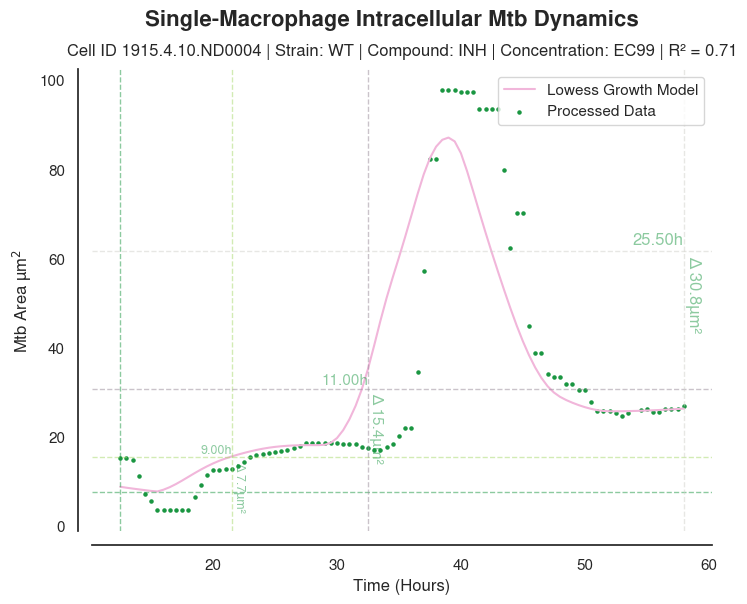

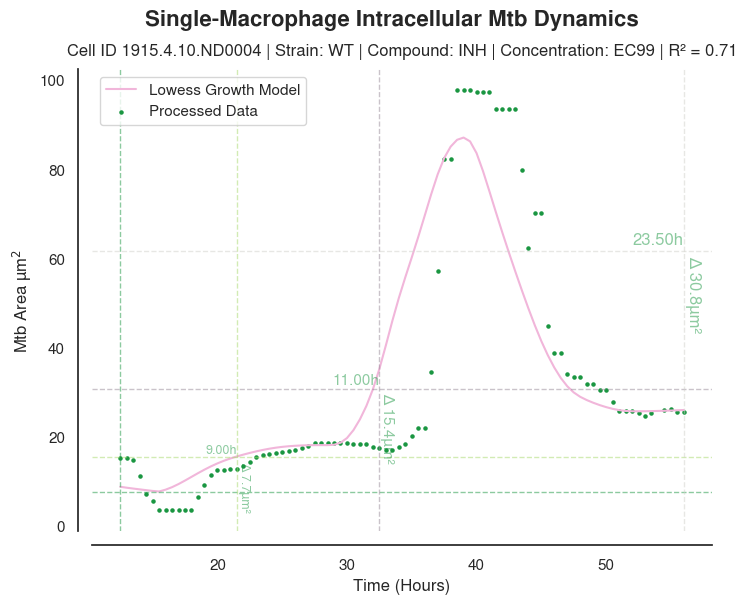

In [28]:
for i, ID in tqdm(enumerate(IDs), total = len(IDs)):
    # if i != 15:
    #     continue
    # Load the video
    glimpse_files = glob.glob(f'/mnt/SYNO/macrohet_syno/glimpses/{ID}.mp4')
    if not glimpse_files:
        print(f"Glimpse file for ID {ID} not found.")
        plt.show()
        continue

    glimpse_fn = glimpse_files[0]

    # Load the video frames using imageio
    video_frames = []
    try:
        reader = imageio.get_reader(glimpse_fn)
        for frame in reader:
            video_frames.append(frame)
        reader.close()
    except Exception as e:
        print(f"Error loading video for ID {ID}: {e}")
        plt.show()
        continue

    # Initialize the Napari viewer
    viewer = napari.Viewer(title=f'ID: {ID} - checking shortest doubling times')

    # Add the video to Napari
    video_frames_array = np.array(video_frames)
    viewer.add_image(video_frames_array, name=f'ID: {ID} Video')

    plot(ID, df, save = False, napari = True)
    viewer.grid.enabled = True
    viewer.dims.current_step = (0, 374, 374)
    
    def mark_transfer(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Transfer'
        print(f"ID {ID} marked as 'Transfer'.")
    
    def mark_uptake(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Uptake'
        print(f"ID {ID} marked as 'Uptake'.")
    
    def mark_junk(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Junk'
        print(f"ID {ID} marked as 'Junk'.")

    def mark_growth(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Growth'
        print(f"ID {ID} marked as 'Growth'.")

    def mark_start(viewer):
        # Get the start index from the viewer
        start_index = viewer.dims.current_step[0]
        # Identify rows to drop up to the start index
        drop_indices = df[df['ID'] == ID].index[:start_index]
        # Drop the identified rows
        df.drop(drop_indices, inplace=True)
        print(f"Start index for ID {ID} marked: {start_index}.")
    
    def mark_stop(viewer):
        # Get the stop index from the viewer
        stop_index = viewer.dims.current_step[0]
        # Identify rows to drop after the stop index
        drop_indices = df[df['ID'] == ID].index[stop_index:]
        # Drop the identified rows
        df.drop(drop_indices, inplace=True)
        print(f"Stop index for ID {ID} marked: {stop_index}.")

    def mark_edge(viewer):
        df.loc[df['ID'] == ID, 'Edge Status'] = True
        print(f"ID {ID} marked as 'Edge Status'.")
    
    def regen_dt_and_graph(viewer):
        regen(ID, df)
        plot(ID, df, save=False, napari=True)
    
    def save_df(viewer):
        df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df_update.pkl')
        print('DataFrame saved out')

    viewer.bind_key('t', mark_transfer)
    viewer.bind_key('u', mark_uptake)
    viewer.bind_key('j', mark_junk)
    viewer.bind_key('>', mark_start, overwrite = True)
    viewer.bind_key('<', mark_stop, overwrite = True)
    viewer.bind_key('r', regen_dt_and_graph)
    viewer.bind_key('s', save_df)
    viewer.bind_key('e', mark_edge)
    viewer.bind_key('g', mark_growth)
    
    viewer.show(block=True)
    plt.close()
    
    # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df_update.pkl')

In [29]:
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/ND4_sc_df.pkl')

In [34]:
df[df['mtb_origin'] == 'Growth'].drop_duplicates('ID').explode('Doubling Times')

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,ID,Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),Frame,Edge Status,r2,Doubling Amounts,Doubling Times,mtb_origin
419080,0.0,98.601415,-53.323431,1212.761644,-978.281579,1.0,1.0,1.0,696.995483,281.722961,...,404.4.5.ND0004,NaN,NaN,NaN,0.0,False,0.78,"[104.4, 208.8]",53.0,Growth
432913,4.0,10.973095,16.381423,498.616538,501.499489,1.0,1.0,1.0,1111.653687,700.664551,...,1038.4.5.ND0004,NaN,NaN,NaN,8.0,False,0.70,"[22.1, 44.2]",18.5,Growth
446498,30.0,6.771584,31.958301,587.049402,95.405585,1.0,1.0,1.0,477.513550,933.643066,...,3849.4.5.ND0004,NaN,NaN,NaN,60.0,False,0.74,"[4.5, 9.0, 18.0, 36.0]",-2.5,Growth
446498,30.0,6.771584,31.958301,587.049402,95.405585,1.0,1.0,1.0,477.513550,933.643066,...,3849.4.5.ND0004,NaN,NaN,NaN,60.0,False,0.74,"[4.5, 9.0, 18.0, 36.0]",17.0,Growth
446498,30.0,6.771584,31.958301,587.049402,95.405585,1.0,1.0,1.0,477.513550,933.643066,...,3849.4.5.ND0004,NaN,NaN,NaN,60.0,False,0.74,"[4.5, 9.0, 18.0, 36.0]",6.0,Growth
448438,35.0,54.463202,34.394283,999.490270,253.431560,1.0,1.0,1.0,918.366516,989.427063,...,4357.4.5.ND0004,NaN,NaN,NaN,70.0,False,0.74,"[23.8, 47.6]",23.0,Growth
455460,0.0,15.934453,1.474998,1395.125094,246.525885,1.0,1.0,1.0,1080.946289,402.497559,...,686.4.6.ND0004,NaN,NaN,NaN,0.0,False,0.79,"[15.5, 31.0]",37.5,Growth
456783,0.0,4.469692,1.743180,1118.629921,516.093035,1.0,1.0,1.0,633.022461,555.314941,...,619.4.6.ND0004,NaN,NaN,NaN,0.0,False,0.72,"[1.92, 3.84]",39.0,Growth
478379,20.0,16.873089,19.018541,583.942966,-334.087160,1.0,1.0,1.0,195.475281,456.344025,...,3120.4.6.ND0004,NaN,NaN,NaN,40.0,False,0.79,"[12.8, 25.6]",40.5,Growth
490876,0.0,11.464761,4.670829,1073.709513,-662.520159,1.0,1.0,1.0,350.005432,191.922668,...,363.4.7.ND0004,NaN,NaN,NaN,0.0,False,0.81,"[8.5, 17.0]",37.5,Growth



### to correct:

389.6.5.PS0000 marked: 7... should it be 24?

512.5.8.PS0000 cropped too much, should start at 4

823.4.6.PS0000 dt correct?

784.5.7.PS0000 crop

733.5.7.PS0000 - check dt

329.4.8.ND0003 - check cropping

620.6.7.PS0000 - check crop check doubling time

### to investigate:

doubling amounts

### Set style for plotting

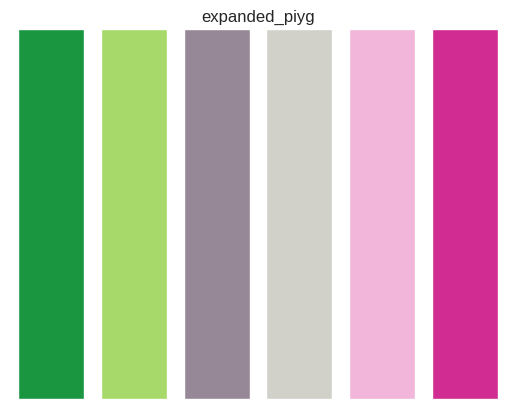

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [3]:
sns.set(style = 'white')

# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

### Load sc df

In [4]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_interp.pkl')
df['dMtb'] = df['delta Mtb max fold-change normalised max area']
df['Mtb'] = df['Intracellular thresholded Mtb content smooth']
# Assuming your DataFrame is named 'df'
df['Strain/Compound'] = df['Compound']  # Create a new column and copy values from 'Compound'
# Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
df.loc[df['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Strain,Compound,Concentration,Technical replicate,Cell ID,Acquisition ID,Unique ID,dMtb,Mtb,Strain/Compound
0,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
1,1,459.138947,6.718642,2314.060291,33.861954,0.0,1.0,0.0,16683.0,344.687042,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
2,2,460.555237,10.785886,2321.198394,54.360864,0.0,1.0,0.0,18935.0,343.875061,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
3,3,455.878815,11.143067,2297.629226,56.161059,1.0,1.0,0.0,19937.0,345.565796,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
4,4,462.634186,14.050420,2331.676296,70.814116,1.0,1.0,0.0,21793.0,350.585083,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296992,70,628.562500,1099.782104,3167.955000,5542.901807,1.0,0.0,1.0,101991.0,377.731873,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.031497,BDQ
296993,71,628.463684,1102.144409,3167.456968,5554.807822,1.0,0.0,1.0,100978.0,377.812103,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.274554,BDQ
296994,72,628.672058,1101.594727,3168.507173,5552.037422,1.0,0.0,1.0,108397.0,376.812805,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.220153,BDQ
296995,73,630.372803,1102.817749,3177.078926,5558.201455,1.0,0.0,1.0,107079.0,377.437073,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.002094,BDQ


### Calculate the maximum gradient for each cell

In [5]:
# df['Max. dMtb gradient'] = np.nan  # Initialize with NaN instead of None
for unique_ID in tqdm(df['Unique ID'].unique()):
    sc_df = df[df['Unique ID'] == unique_ID]

    max_gradient = sc_df['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).max()
    df.loc[df['Unique ID'] == unique_ID, 'Max. dMtb gradient'] = max_gradient
    if max_gradient > 120:
        print(unique_ID)

  0%|          | 0/3988 [00:00<?, ?it/s]

280.3.5
85.4.5


### Load metadata

In [6]:
base_dir = '/mnt/DATA/macrohet/'
metadata_path = os.path.join(base_dir, 'macrohet_images/PS0000/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

In [7]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/PS0000/'
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


## Load outliers

In [8]:
N = 100
top_N_tracks = df.groupby('Unique ID')['Max. dMtb gradient'].max().sort_values(ascending=False).head(N)

## Plot some outliers

In [ ]:

# Plot 'Mtb' and the calculated gradient against 'Time (hours)' for each of the top ten tracks
for n, track_id in tqdm(enumerate(top_N_tracks.keys()), total = len(top_N_tracks.keys())):
    
    if n == 10:
        break
    # Extract rows corresponding to the current track
    track_data = df[df['Unique ID'] == track_id]

    # Convert to NumPy array for compatibility
    time_values = track_data['Time (hours)'].values
    mtb_values = track_data['Mtb'].values
    gradient_values = track_data['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).values

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Plot Mtb values
    color = expanded_piyg[0]
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Mtb Value', color=color)
    ax1.plot(time_values, mtb_values, label=f'Intracellular Mtb (Unique ID: {track_id})', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a twin axis for the gradient
    ax2 = ax1.twinx() 
    color = expanded_piyg[-1]
    ax2.set_ylabel('Gradient', color=color)  
    ax2.plot(time_values, gradient_values, label='Gradient', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')

    plt.title(f'Mtb and Gradient vs Time for Track {track_id}')
    fig.tight_layout()
    sns.despine(offset = 10, right = False)
    plt.show()

    # get acq ID and ID from track id'
    acq_ID = track_data['Acquisition ID'].iloc[0]
    cell_ID = track_data['Cell ID'].iloc[0]
    # get images 
    row, column = acq_ID
    image_dir = os.path.join(base_dir, 'Images')
    images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, column, 
                                 set_plane='max_proj',
                                 # set_channel=1,
                                 # set_time = 1,
    #                             input_transforms = [input_transforms]
                                )#.compute().compute()
    glimpse = visualise.create_glimpse_from_sc_df(track_data, acq_ID, cell_ID, images)
    loaded_glimpse = glimpse.compute().compute()
    glimpse_dict[track_id] = loaded_glimpse

    filename = f"{directory}{track_id}.npy"
    
    # Save the image
    np.save(filename, loaded_glimpse)

    # Store the filename in the dictionary
    filenames_dict[key] = filename

## Load segmentation

In [9]:
tracks_dict = dict()
segmentation_dict = dict()

### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(f'/mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/{row,column}.h5', 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
        seg = reader.segmentation

            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks
    segmentation_dict[(row, column)] = seg

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/11/27 12:09:14 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
[INFO][2023/11/27 12:09:14 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/11/27 12:09:14 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/11/27 12:09:14 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/11/27 12:09:25 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/11/27 12:09:25 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
[INFO][2023/11/27 12:09:25 PM] Opening HDF file: /mnt/DATA/macrohet/labels/P

# Investigate single cell plots

In [65]:
investigate_IDs = [
 '389.6.5.PS0000',
 '512.5.8.PS0000',
 '823.4.6.PS0000',
 '784.5.7.PS0000',
 '733.5.7.PS0000',
 '329.4.8.ND0003',
 '620.6.7.PS0000']

In [139]:
df[df['ID'] ==  '620.6.7.PS0000']

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
1097652,620.6.7.PS0000,0.0,10.481429,12.93976,777.547693,1477.948495,NaN,True,True,14.914679,...,True,False,NaN,NaN,NaN,NaN,Growth,"[12.5, 25.0]",[32.0],0.89
1097653,620.6.7.PS0000,1.0,20.985206,12.93976,1406.053492,1477.948495,NaN,True,True,26.234379,...,True,False,10.503777,NaN,NaN,NaN,Growth,"[12.5, 25.0]",[32.0],0.89
1097654,620.6.7.PS0000,2.0,13.833698,12.93976,1095.476915,1477.948495,True,True,True,20.595766,...,True,False,-7.151508,NaN,2.0,24.587460,Growth,"[12.5, 25.0]",[32.0],0.89
1097655,620.6.7.PS0000,3.0,25.119671,12.93976,NaN,1477.948495,True,True,True,17.953283,...,True,False,11.285973,NaN,3.0,24.358292,Growth,"[12.5, 25.0]",[32.0],0.89
1097656,620.6.7.PS0000,4.0,17.588240,12.93976,1575.767713,1477.948495,True,True,True,33.118710,...,True,False,-7.531432,17.588240,4.0,24.096519,Growth,"[12.5, 25.0]",[32.0],0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097722,620.6.7.PS0000,70.0,25.209065,12.93976,2507.005780,1477.948495,True,True,True,56.981956,...,True,False,0.312878,25.209065,70.0,25.789138,Growth,"[12.5, 25.0]",[32.0],0.89
1097723,620.6.7.PS0000,71.0,25.790125,12.93976,2576.017831,1477.948495,True,True,True,58.514717,...,True,False,0.581060,25.790125,71.0,25.939044,Growth,"[12.5, 25.0]",[32.0],0.89
1097724,620.6.7.PS0000,72.0,26.840503,12.93976,2619.642029,1477.948495,True,True,True,54.296745,...,True,False,1.050378,25.790125,72.0,26.085196,Growth,"[12.5, 25.0]",[32.0],0.89
1097725,620.6.7.PS0000,73.0,27.265124,12.93976,2152.626217,1477.948495,NaN,True,True,54.374306,...,True,False,0.424621,25.790125,NaN,NaN,Growth,"[12.5, 25.0]",[32.0],0.89


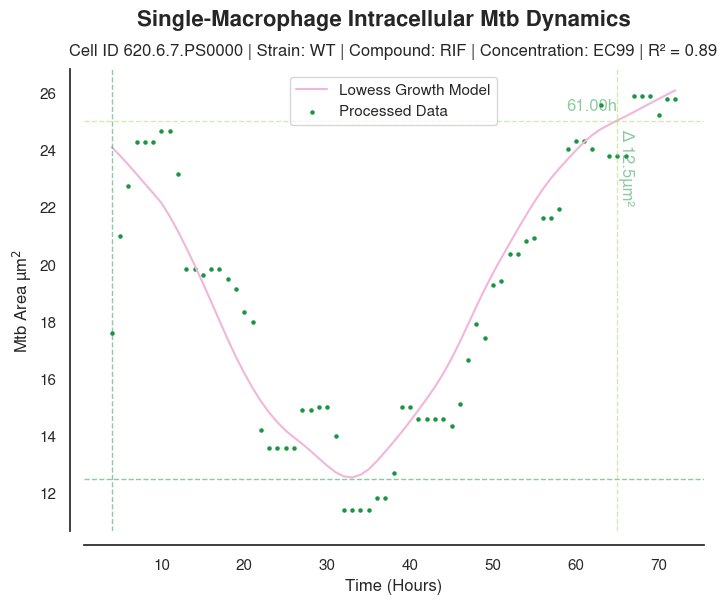

In [140]:
plot('620.6.7.PS0000', df, save=False, napari=False)

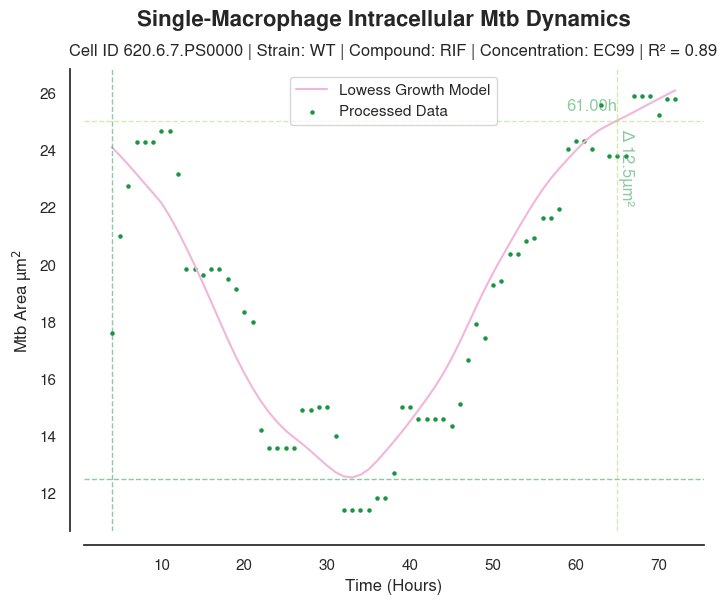

In [141]:
ID = '620.6.7.PS0000'
# Get single-cell trajectory in df format
sc_df = df[df['ID'] == ID]
# Drop NaN values specifically from the required columns
sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
# Ensure there is temporal order
sc_df = sc_df.sort_values(by='Time Model (hours)')

# Extract Strain, Compound, and Concentration for the title
strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values

# Calculate the R2 value and skip plotting if R2 < 0.7
r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
df.loc[df['ID'] == ID, 'r2'] = r2
if r2 < 0.7:
    # ill_fitting_curves[ID] = r2
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
    # df.loc[df['ID'] == ID, 'Doubling Times'] = None
    print(f'Nee fitting ({r2})')
    # return

# Find the temporal order of the minimum and maximum
min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
max_value = sc_df['Mtb Area Model (µm)'].round(1).max()

# perform a check on the data
if max_value <= min_value:
    #non_doubling_curves.append(ID)
    print(f'No population doubling for ID {ID}')

# Find the time indices of the minimum and maximum
min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()

# Check if maximum occurs before minimum
if max_index > min_index:
    growth = True
    # Minimum occurs before the maximum (indicating growth)
    # Start from the minimum and double
    N_i = min_value
    N_series = []
    
    # Generate the doubling series
    while N_i <= max_value:
        N_series.append(N_i)
        N_i *= 2
    
else:
    growth = False
    # non_doubling_curves.append(ID)
    print(f'No obvious growth for ID {ID}')
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
    # df.loc[df['ID'] == ID, 'Doubling Times'] = None
    # return
    # Maximum occurs before the minimum (indicating a reduction)
    # Start from the maximum and halve
    N_i = max_value
    N_series = []
    
    # Generate the halving series
    while N_i >= min_value:
        N_series.append(N_i)
        N_i /= 2

# Check if there are no valid doubling points
if len(N_series) < 2:
    #non_doubling_curves.append(ID)
    print(f'No population doubling for ID {ID}')
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
    # df.loc[df['ID'] == ID, 'Doubling Times'] = None
    # return
    
# Find the indices and corresponding times for each doubling point
doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
doubling_times = doubling_time_points.diff().dropna().values.tolist()

# if not growth:
#     doubling_times = [-t for t in doubling_times]
#     N_series = [-n for n in N_series]  

# Incorporate N_series and doubling_times into the main DataFrame
# Assign lists to all entries in df with the same ID
# df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
# df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
# # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(8, 6))
plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)

# Annotate doubling times and draw faint lines
for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
    time = abs(time)
    population = abs(population)
    color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
    # Draw faint vertical lines at doubling time points
    plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
    plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
    
    # Place a text label indicating the doubling time
    if i > 0:  # Start labeling from the second point
        previous_time = doubling_time_points.iloc[i-1]
        
        # Midpoint between the two lines
        label_x_pos = time  # Correct the label position
        # Adjust y-position to place the label just above the horizontal line
        label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line

        # Calculate the gap between the lines and scale the font size
        gap = time - previous_time
        scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
        
        # Draw the horizontal doubling time label
        plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                 ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
        
        # Draw vertical arrow showing the change in N_series (doubling amount)
        deltaMtb = population - N_series[i-1]
        
        # Midpoint for the vertical delta annotation
        text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
        text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population

        # Midpoint between the two lines
        label_x_pos = time + 0.1  # Adjust x-position
        # Adjust y-position to place the label just above the horizontal line
        label_y_pos = population - (max_value * 0.01)
        
        # Place the vertical label using plt.text
        plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                 fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)

# Add labels, legend, and titles
plt.xlabel('Time (Hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
    # Main title
plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
             weight='bold', fontsize=16)
# Subtitle
plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)

sns.despine(offset=10)
plt.grid(False)

In [142]:
sc_df

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
1097656,620.6.7.PS0000,4.0,17.588240,12.93976,1575.767713,1477.948495,True,True,True,33.118710,...,True,False,-7.531432,17.588240,4.0,24.096519,Growth,"[12.5, 25.0]",[32.0],0.89
1097657,620.6.7.PS0000,5.0,24.270430,12.93976,2134.278129,1477.948495,True,True,True,48.294697,...,True,False,6.682190,20.985206,5.0,23.803772,Growth,"[12.5, 25.0]",[32.0],0.89
1097658,620.6.7.PS0000,6.0,22.728386,12.93976,1895.864736,1477.948495,True,True,True,41.692436,...,True,False,-1.542044,22.728386,6.0,23.487463,Growth,"[12.5, 25.0]",[32.0],0.89
1097659,620.6.7.PS0000,7.0,24.650354,12.93976,2367.953649,1477.948495,True,True,True,53.302074,...,True,False,1.921968,24.270430,7.0,23.156966,Growth,"[12.5, 25.0]",[32.0],0.89
1097660,620.6.7.PS0000,8.0,37.478371,12.93976,2290.225698,1477.948495,True,True,True,57.197620,...,True,False,12.828017,24.270430,8.0,22.821729,Growth,"[12.5, 25.0]",[32.0],0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097720,620.6.7.PS0000,68.0,33.723829,12.93976,2615.708700,1477.948495,True,True,True,53.764103,...,True,False,7.821962,25.901868,68.0,25.482374,Growth,"[12.5, 25.0]",[32.0],0.89
1097721,620.6.7.PS0000,69.0,24.896187,12.93976,2302.986670,1477.948495,True,True,True,51.049397,...,True,False,-8.827643,25.901868,69.0,25.636442,Growth,"[12.5, 25.0]",[32.0],0.89
1097722,620.6.7.PS0000,70.0,25.209065,12.93976,2507.005780,1477.948495,True,True,True,56.981956,...,True,False,0.312878,25.209065,70.0,25.789138,Growth,"[12.5, 25.0]",[32.0],0.89
1097723,620.6.7.PS0000,71.0,25.790125,12.93976,2576.017831,1477.948495,True,True,True,58.514717,...,True,False,0.581060,25.790125,71.0,25.939044,Growth,"[12.5, 25.0]",[32.0],0.89


In [143]:
doubling_time_points

1097656     4.0
1097717    65.0
Name: Time Model (hours), dtype: float64

In [144]:
doubling_times

[61.0]

In [64]:
df.loc[df['ID'] == '1447.4.4.ND0003', 'mtb_origin'] = 'Growth'

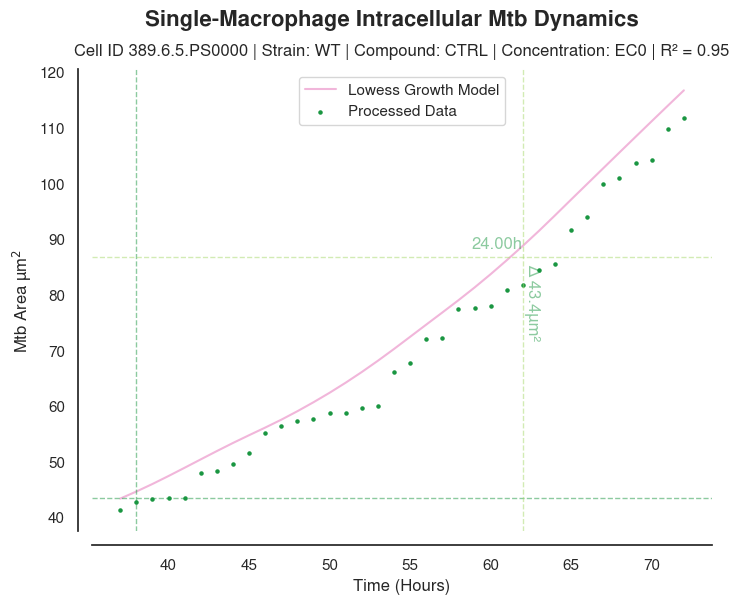

Nee fitting (0.35)
No population doubling for ID 512.5.8.PS0000


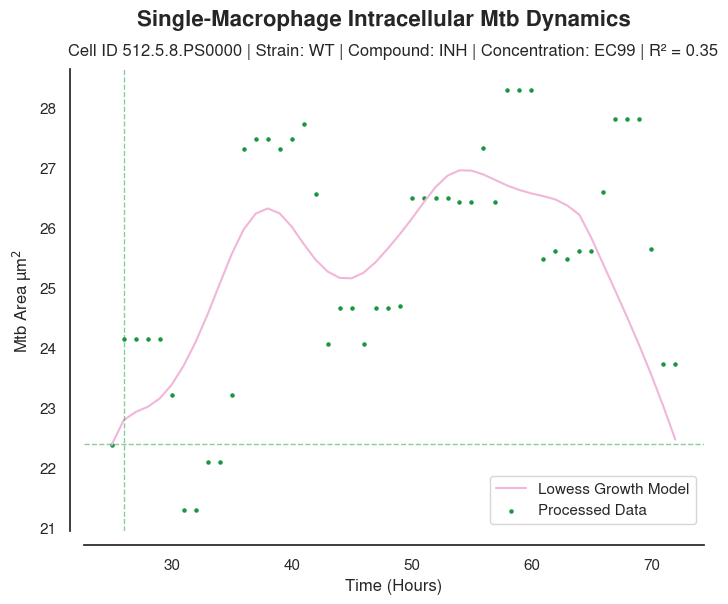

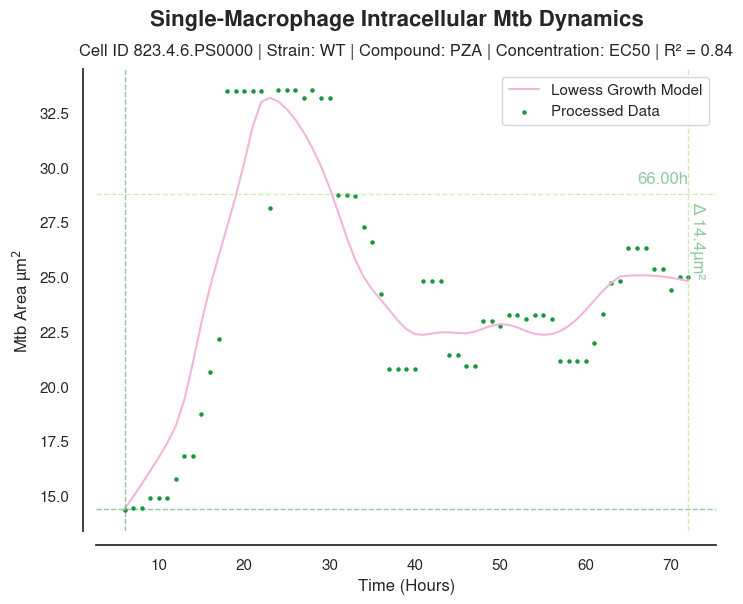

Nee fitting (0.59)


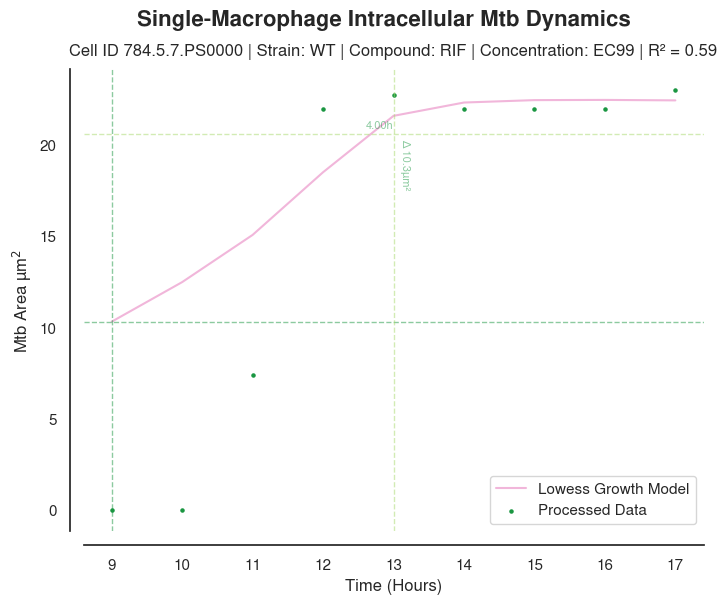

Nee fitting (0.38)


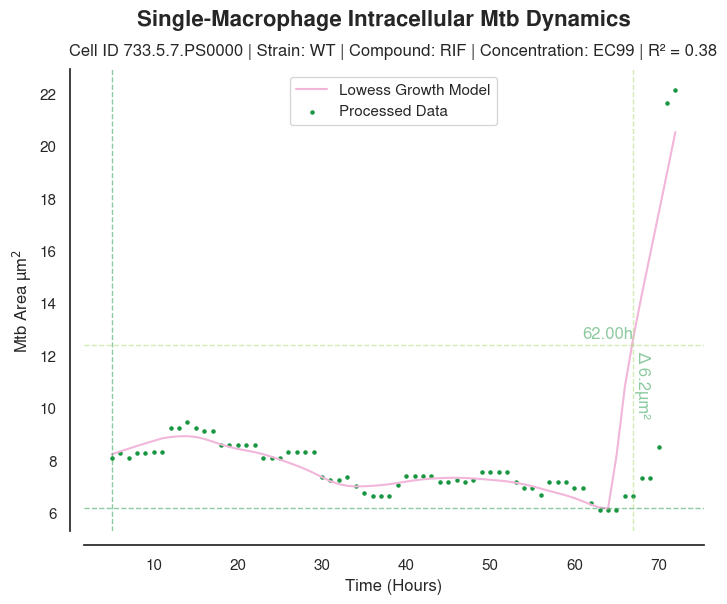

Nee fitting (0.59)


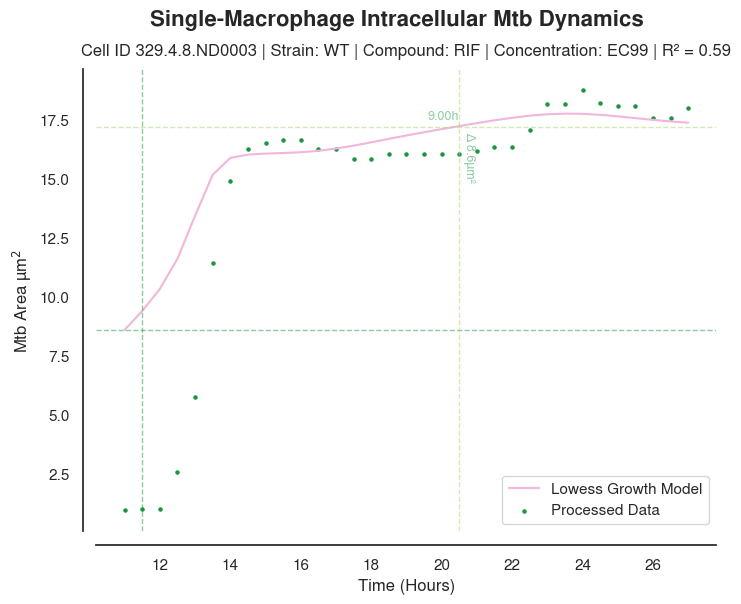

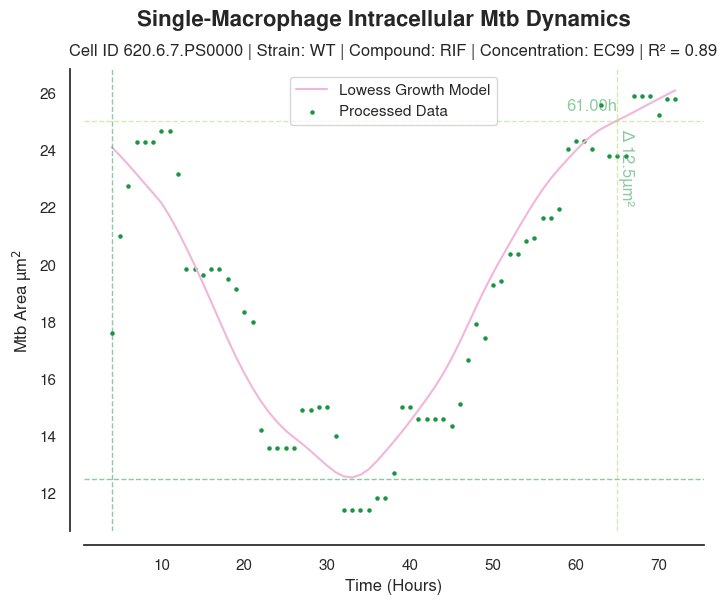

In [66]:
for ID in investigate_IDs:
    plot(ID, df, save=False, napari=False)